In [3]:
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# ! cp "/content/gdrive/My Drive/Colab Notebooks/ICV/Dataset.zip" "/content/Dataset.zip"

In [ ]:
# ! unzip Dataset.zip

In [6]:
# import libraries

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

import torch
from torch import nn, optim

from torchvision.transforms import transforms
from tqdm import tqdm, trange

import matplotlib.pyplot as plt


In [7]:
def show_in_row(list_of_images: list, titles: list = None, disable_ticks: bool = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
      
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
dev = 'cpu'
if torch.cuda.is_available():
    dev = 'cuda'

print(f'using device: {dev}')
dev = torch.device(dev)

using device: cuda


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

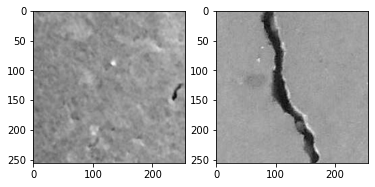

In [79]:
RANDOM_STATE = 42
# Data

DATA_ROOT = 'Dataset'

TEST_SIZE = 0.1
TRAIN_BATCH = 256
VALID_BATCH = 1024
IMG_SIZE = (256, 256)

# todo: add randomized augmentation as transform for train samples

dataset_transform = transforms.Compose(
        [
            transforms.Resize(IMG_SIZE),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )

dataset = ImageFolder(DATA_ROOT, transform=dataset_transform, target_transform=None)


splitter = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
splits = splitter.split(X=np.arange(len(dataset), dtype=np.int), y=dataset.targets)

train_idx, valid_idx = next(splits)

train0_idx = np.intersect1d(train_idx, np.where(np.asarray(dataset.targets)==0))
train1_idx = np.intersect1d(train_idx, np.where(np.asarray(dataset.targets)==1))

print(dataset.targets)
print(train0_idx)
print(train1_idx)

train_ds = Subset(dataset, train_idx)
train0_ds = Subset(dataset, train0_idx)
train1_ds = Subset(dataset, train1_idx)
valid_ds = Subset(dataset, valid_idx)

train0_dl = DataLoader(train0_ds, batch_size=TRAIN_BATCH, shuffle=True,  num_workers=0)
train1_dl = DataLoader(train1_ds, batch_size=TRAIN_BATCH, shuffle=True,  num_workers=0)
valid_dl  = DataLoader(valid_ds, batch_size=VALID_BATCH, shuffle=False, num_workers=0)

imgs = [
    train0_ds[0][0].permute(1, 2, 0).reshape((256, 256)), 
    train1_ds[0][0].permute(1, 2, 0).reshape((256, 256))
]

show_in_row(imgs)


In [80]:
class InterpolateUp(nn.Module):
    def __init__(self, factor, mode):
        super(InterpolateUp, self).__init__()
        self.interp = nn.functional.interpolate
        self.factor = factor
        self.mode = mode

    def forward(self, x):
        t = x.shape[-1]
        x = self.interp(x, size=t * self.factor, mode=self.mode)
        return x

    

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        
        # label
        self.default_label = 0
        
        self.lr = 0.1
        self.conv_dim = cd = 2
        self.leaky_relu = 0.001
        self.interpolation_mode = 'bilinear'

        self.conv = lambda c_in, c_out: nn.Conv2d(c_in, c_out, kernel_size=3, padding=1)
        self.deconv = lambda c_in, c_out: nn.ConvTranspose2d(c_in, c_out, kernel_size=3, padding=1)
        
        self.sigmoid = nn.LeakyReLU(self.leaky_relu, inplace=True)
        self.batch_norm = lambda x: nn.BatchNorm2d(x)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.X2interpolate = InterpolateUp(2, mode=self.interpolation_mode)


        # layers of the component
        self.encoder = nn.Sequential(
            *[
                # 1
                self.conv(1, cd),          # 32, 1, 256, 256 -> 32, cd, 256, 256
                self.batch_norm(cd),       # 
                self.sigmoid,              #
                self.max_pool,             # 32, cd, 128, 128

                # 2
                self.conv(cd, cd * 2),     # 32, 2cd, 128, 128
                self.batch_norm(cd * 2),   # 32, 2cd, 128, 128
                self.sigmoid,              # 32, 2cd, 128, 128
                self.max_pool,             # 32, 2cd,  64,  64
            ]
        )   
        
        
        self.decoder = nn.Sequential(
            *[
                # 2
                self.deconv(cd * 2, cd),
                self.batch_norm(cd),
                self.sigmoid,

                # self.max_pool,
                self.X2interpolate,

                # 1
                self.deconv(cd, 1),
                self.batch_norm(1),
                self.sigmoid,
                # self.max_pool,
                self.X2interpolate,
            ]
        )
        
        # optimizer
        self.optimizer = optim.Adam(self.parameters(), self.lr)
        

    def forward(self, x):
#         out = x
#         print(f'shape 0 : {out.shape}')
#         for l in list(self.encoder) + list(self.decoder):
#             out = l(out)
#             print('shape {:100} : {}'.format(l.__str__(), out.shape))
#         return out
        latent = self.encoder(x)
        return self.decoder(latent)
    
    def loss_func(self, data, reconstruction):
        return torch.mean((data - reconstruction) ** 2)
  
    def reconstruct(self, data):
        with torch.no_grad():
            data = data.to(dev)
            data = data.view(1, 1, IMG_SIZE[0], IMG_SIZE[1])
            out = self.forward(data)
            out = out.view(1, IMG_SIZE[0], IMG_SIZE[1])

            loss = self.loss_func(data.view(IMG_SIZE), out.view(IMG_SIZE))

            return out.cpu(), loss.cpu()
    

    def predict_loss(self, data_label):
        with torch.no_grad():
            data, _  = data_label
            data = data.to(dev)
            
            reconstruction = self.forward(data)
            return self.loss_func(data, reconstruction)

    def step(self, data_label):
        self.optimizer.zero_grad()
        
        data, _  = data_label
        data = data.to(dev)

        reconstruction = self.forward(data)
        loss = self.loss_func(data, reconstruction)

        loss.backward()
        self.optimizer.step()

        return loss
    
    def train(self, dl):
        self.iters = 200
        self.log_rate = 100
        
        loader = iter(dl)
        pbar = range(self.iters)
        for it in pbar: 
            try:
                batch = next(loader)
            except StopIteration:
                loader = iter(dl)
                batch = next(loader)

            loss = self.step(batch)
            if it == 0 or (it + 1) % self.log_rate == 0: 
                print(f'\t\tLOSS at {it+1}: {loss}')



    def test(self, dl):
        with torch.no_grad():
            losses = [self.predict_loss(batch) for batch in (dl)]
        
            return torch.mean(torch.stack(losses))



model = EncoderDecoder()
model.to(dev)

model.train(train0_dl)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


		LOSS at 1: 0.8807741403579712
		LOSS at 100: 0.0030899664852768183
		LOSS at 200: 0.002444213954731822


In [81]:
l1 = model.test(train1_dl)
print(f'LOSS 1 {l1}')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LOSS 1 0.012697450816631317


In [82]:
losses = [(model.reconstruct(s[0])[1], s[1]) for s in (train_ds)]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


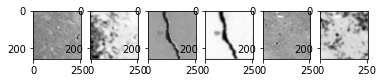

In [83]:
imgs = [
    train0_ds[0][0].reshape((256, 256)), 
    model.reconstruct(train0_ds[0][0])[0].reshape((256, 256)), 

    train1_ds[0][0].reshape((256, 256)),
    model.reconstruct(train1_ds[0][0])[0].reshape((256, 256)), 

    valid_ds[0][0].reshape((256, 256)),
    model.reconstruct(valid_ds[0][0])[0].reshape((256, 256)), 
]

imgs = [i.cpu() for i in imgs]


show_in_row(imgs)

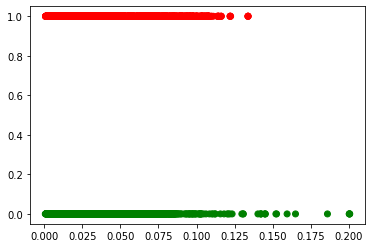

In [84]:
xs = []
ys = []

xs, ys = list(zip(*losses))

xs = np.asarray(xs ,dtype = np.float)
colors = ['green' if y==0 else 'red' for y in ys]
plt.scatter(xs, ys, c=colors)
plt.show()